## Visualisation tools

In [33]:
import logging
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
import matplotlib
matplotlib.use('TkAgg')

In [34]:
from aimapp.visualisation_tools import plot_likelihood, pickle_load_model, plot_state_in_map
import numpy as np
import networkx as nx
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import colors

In [35]:
def plot_transitions_per_actions(B, agent_state_mapping,possible_actions, selected_actions=[]):
    labels = [value['state'] for value in agent_state_mapping.values()]
    actions_plots = []
    l = len(labels) *1.5
    for action in range(len(possible_actions)):
        if len(selected_actions) > 0 and action not in selected_actions:
            continue
        fig = plt.figure(action, figsize=(l,l))
        a = B[2:4,:len(labels),action]
        fig = sns.heatmap(a, linewidth=0.5, vmin=0,vmax=1.0 ,cmap="YlOrBr", xticklabels=labels, yticklabels=['2','3'])
        fig.tick_params(axis='both', which='major', labelsize=14)  # Adjust label font size
        fig.set_title(possible_actions[action], fontsize=20)
        fig.set_xlabel('Prev State', fontsize=16)
        fig.set_ylabel('Next State', fontsize=16)
        
        actions_plots.append(fig)
    return actions_plots

In [36]:
def plot_transitions(B: np.ndarray, state_map: dict, actions: dict) -> np.ndarray:
    """Plot Transitions matrix showing the probability of a transition between two states given a certain action."""
    
    sorted_state_map = dict(sorted(state_map.items(), key=lambda item: item[1]['state']))
    labels = [f"{key} ({value['state']})" for key, value in sorted_state_map.items()]
    print('labels',labels)
    n_actions = len(actions)
    l = int(np.ceil(np.sqrt(n_actions)))
    L = int(np.ceil(n_actions / l))
    
    fig, axes = plt.subplots(L, l)
    
    axes = np.atleast_2d(axes)  # Ensure axes is always a 2D array
    count = 0
    print('L and l', L,l)
    for i in range(L):
        for j in range(l):
            if count >= n_actions:
                fig.delaxes(axes[i][j])
                continue
            
            if count not in actions:
                print(count, 'not in actions, n actions',n_actions)
                continue

            action_str = str(actions[count])  # Convert action name to string

            # Plot the heatmap
            g = sns.heatmap(B[:len(labels), :len(labels), count], cmap="OrRd", linewidth=3, 
                            cbar=False, ax=axes[i, j], xticklabels=labels, yticklabels=labels)

            g.tick_params(axis='both', which='major', labelsize=14)  # Adjust label font size
            g.set_title(action_str, fontsize=20)
            g.set_xlabel('Prev State', fontsize=16)
            g.set_ylabel('Next State', fontsize=16)

            # Rotate labels for better visibility
            g.set_xticklabels(labels, rotation=45, ha="right", fontsize=12)
            g.set_yticklabels(labels, rotation=0, fontsize=12)
            
            count += 1

    plt.subplots_adjust(left=0.2, bottom=0.2)  # Add margin space
    plt.tight_layout()
    return fig


In [37]:
def compare_B1_B2_plots(B1: np.ndarray, B2: np.ndarray, state_map: dict, actions: dict) -> np.ndarray:
    """Plot Transitions matrix showing the probability of a transition between two states given a certain action.
       Common values in B1 and B2 (within a margin of 0.1) are set to 0 in the resulting B.
    """
    
    # Create B by zeroing out common values within margin 0.1
    margin = 0.1
    B = np.where(np.abs(B1 - B2) <= margin,0, B2)
    
    sorted_state_map = dict(sorted(state_map.items(), key=lambda item: item[1]['state']))
    labels = [f"{key} ({value['state']})" for key, value in sorted_state_map.items()]

    n_actions = len(actions)
    l = int(np.ceil(np.sqrt(n_actions)))
    L = int(np.ceil(n_actions / l))
    
    fig, axes = plt.subplots(L, l, figsize=(L*3 + max(10, 2.5*len(state_map)), 
                                             l*2 + max(10, 1.5*len(state_map))))
    
    axes = np.atleast_2d(axes)  # Ensure axes is always a 2D array
    count = 0

    for i in range(L):
        for j in range(l):
            if count >= n_actions:
                fig.delaxes(axes[i][j])
                continue
            
            if count not in actions:
                continue

            action_str = str(actions[count])  # Convert action name to string

            # Plot the heatmap
            g = sns.heatmap(B[:len(labels), :len(labels), count], cmap="OrRd", linewidth=3, 
                            cbar=False, ax=axes[i, j], xticklabels=labels, yticklabels=labels)

            g.tick_params(axis='both', which='major', labelsize=14)  # Adjust label font size
            g.set_title(action_str, fontsize=20)
            g.set_xlabel('Prev State', fontsize=16)
            g.set_ylabel('Next State', fontsize=16)

            # Rotate labels for better visibility
            g.set_xticklabels(labels, rotation=45, ha="right", fontsize=12)
            g.set_yticklabels(labels, rotation=0, fontsize=12)
            
            count += 1

    plt.subplots_adjust(left=0.2, bottom=0.2)  # Add margin space
    plt.tight_layout()

    return fig, B

In [38]:
def plot_mcts_tree(root_node):
    """Visualises the Monte Carlo Tree Search (MCTS) tree."""
    G = nx.DiGraph()  # Directed Graph
    dico = {}
    visited = set()  # To avoid infinite recursion

    # Recursively extract tree structure
    def add_nodes_edges(node, parent=None, action=None):
        if node.id in visited:
            if parent is not None:
                G.add_edge(parent.id, node.id, action=int(action))
            return  # Already added and traversed — skip further traversal

        visited.add(node.id)

        # Aggregate or update visit count
        if node.id not in dico:
            dico[node.id] = node.N
        else:
            dico[node.id] += node.N

        # Label for display
        node_label = f"ID: {node.id}\nN: {round(dico[node.id], 2)},\nR: {round(node.state_reward, 2)}"
        G.add_node(node.id, label=node_label, reward=dico[node.id])

        if parent is not None:
            G.add_edge(parent.id, node.id, action=int(action))

        if node.has_children_nodes():
            for action, child_node in node.childs.items():
                add_nodes_edges(child_node, node, action)

    add_nodes_edges(root_node)

    dico = sorted(dico.items(), key=lambda x: x[1])
    logging.info(f"max visits:{dico}, len dict:{len(dico)}")

    pos = nx.kamada_kawai_layout(G)
    # Scale positions to increase spacing
    pos = {k: (x * 1.5, y * 1.5) for k, (x, y) in pos.items()}

    # Node colors based on reward
    rewards = [G.nodes[n]['reward'] for n in G.nodes]
    min_reward = min(rewards) if rewards else 0
    max_reward = max(rewards) if rewards else 1
    node_colors = [(r - min_reward) / (max_reward - min_reward + 1e-6) for r in rewards]

    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'),
            node_color=node_colors, cmap=plt.cm.cool, node_size=1500,
            font_size=8, font_weight='bold', edgecolors="black", alpha=0.9)

    # Draw edge labels (actions)
    edge_labels = nx.get_edge_attributes(G, 'action')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7, label_pos=0.7)

    plt.title("Monte Carlo Tree Search (MCTS) Visualization")
    plt.show()

## Model 

In [ ]:
import matplotlib
%matplotlib inline
import logging

In [39]:
from aimapp.model.pymdp.agent import Agent
from aimapp.model.odometry import PoseOdometry
from aimapp.model.pymdp import utils
from aimapp.model.V5 import Ours_V5_RW
from aimapp.model.modules import *
import copy


In [40]:
import pickle
def pickle_load_model(store_path: str = None):
    """Loads a pickled model from the specified path."""
    store_path = Path(store_path)
    if not store_path.exists():
        logging.error(f"Model file not found at: {store_path}")
        return None
    try:
        with open(store_path, 'rb') as f:
            loaded_model = pickle.load(f)
            logging.info(f"Model successfully loaded from: {store_path}")
            return loaded_model
    except Exception as e:
        logging.error(f"Failed to load model from {store_path}: {e}")
        return None

In [41]:
influence_radius = 1.0 #m, no node created under that threshold
lookahead_policy = 10 #MCTS depth limit, 
lookahead_node_creation = 8 #how many successive nodes we will create

In [54]:
ob_id = 0
pose_id = 0
obstacle_dist_per_actions  = [16.807, 7.002, 3.485, 2.0879, 4.285, 13.905, 14.785, 5.634, 19.275, 5.747, 4.0156, 7.973]

In [55]:
ours = Ours_V5_RW(num_obs=2, num_states=2, dim=2, n_actions=13, observations=[ob_id], influence_radius=influence_radius,robot_dim=0.3, lookahead_policy=lookahead_policy, lookahead_node_creation=lookahead_node_creation)

In [56]:
ours.update_transition_nodes(obstacle_dist_per_actions=obstacle_dist_per_actions)
ours.update_C_dim()

update_B: a 0 qs[factor] [0.001 0.001 0.998] qs_prev[factor] [0. 1. 0.]
update_B: a 6 qs[factor] [0. 1. 0.] qs_prev[factor] [0.001 0.001 0.998]
update_B: a 0 qs[factor] [0.001 0.001 0.001 0.997] qs_prev[factor] [0.001 0.001 0.998 0.   ]
update_B: a 6 qs[factor] [0.001 0.001 0.998 0.   ] qs_prev[factor] [0.001 0.001 0.001 0.997]
update_B: a 0 qs[factor] [0.001 0.001 0.001 0.001 0.996] qs_prev[factor] [0.001 0.001 0.001 0.997 0.   ]
update_B: a 6 qs[factor] [0.001 0.001 0.001 0.997 0.   ] qs_prev[factor] [0.001 0.001 0.001 0.001 0.996]
update_B: a 0 qs[factor] [0.001 0.001 0.001 0.001 0.001 0.995] qs_prev[factor] [0.001 0.001 0.001 0.001 0.996 0.   ]
update_B: a 6 qs[factor] [0.001 0.001 0.001 0.001 0.996 0.   ] qs_prev[factor] [0.001 0.001 0.001 0.001 0.001 0.995]
update_B: a 0 qs[factor] [0.003 0.003 0.003 0.003 0.003 0.003 0.98 ] qs_prev[factor] [0.001 0.001 0.001 0.001 0.001 0.995 0.   ]
update_B: a 6 qs[factor] [0.001 0.001 0.001 0.001 0.001 0.995 0.   ] qs_prev[factor] [0.003 0.003

In [57]:
ours.qs[0].round(3)

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [ ]:
stop

NameError: name 'stop' is not defined

## plot model step 0

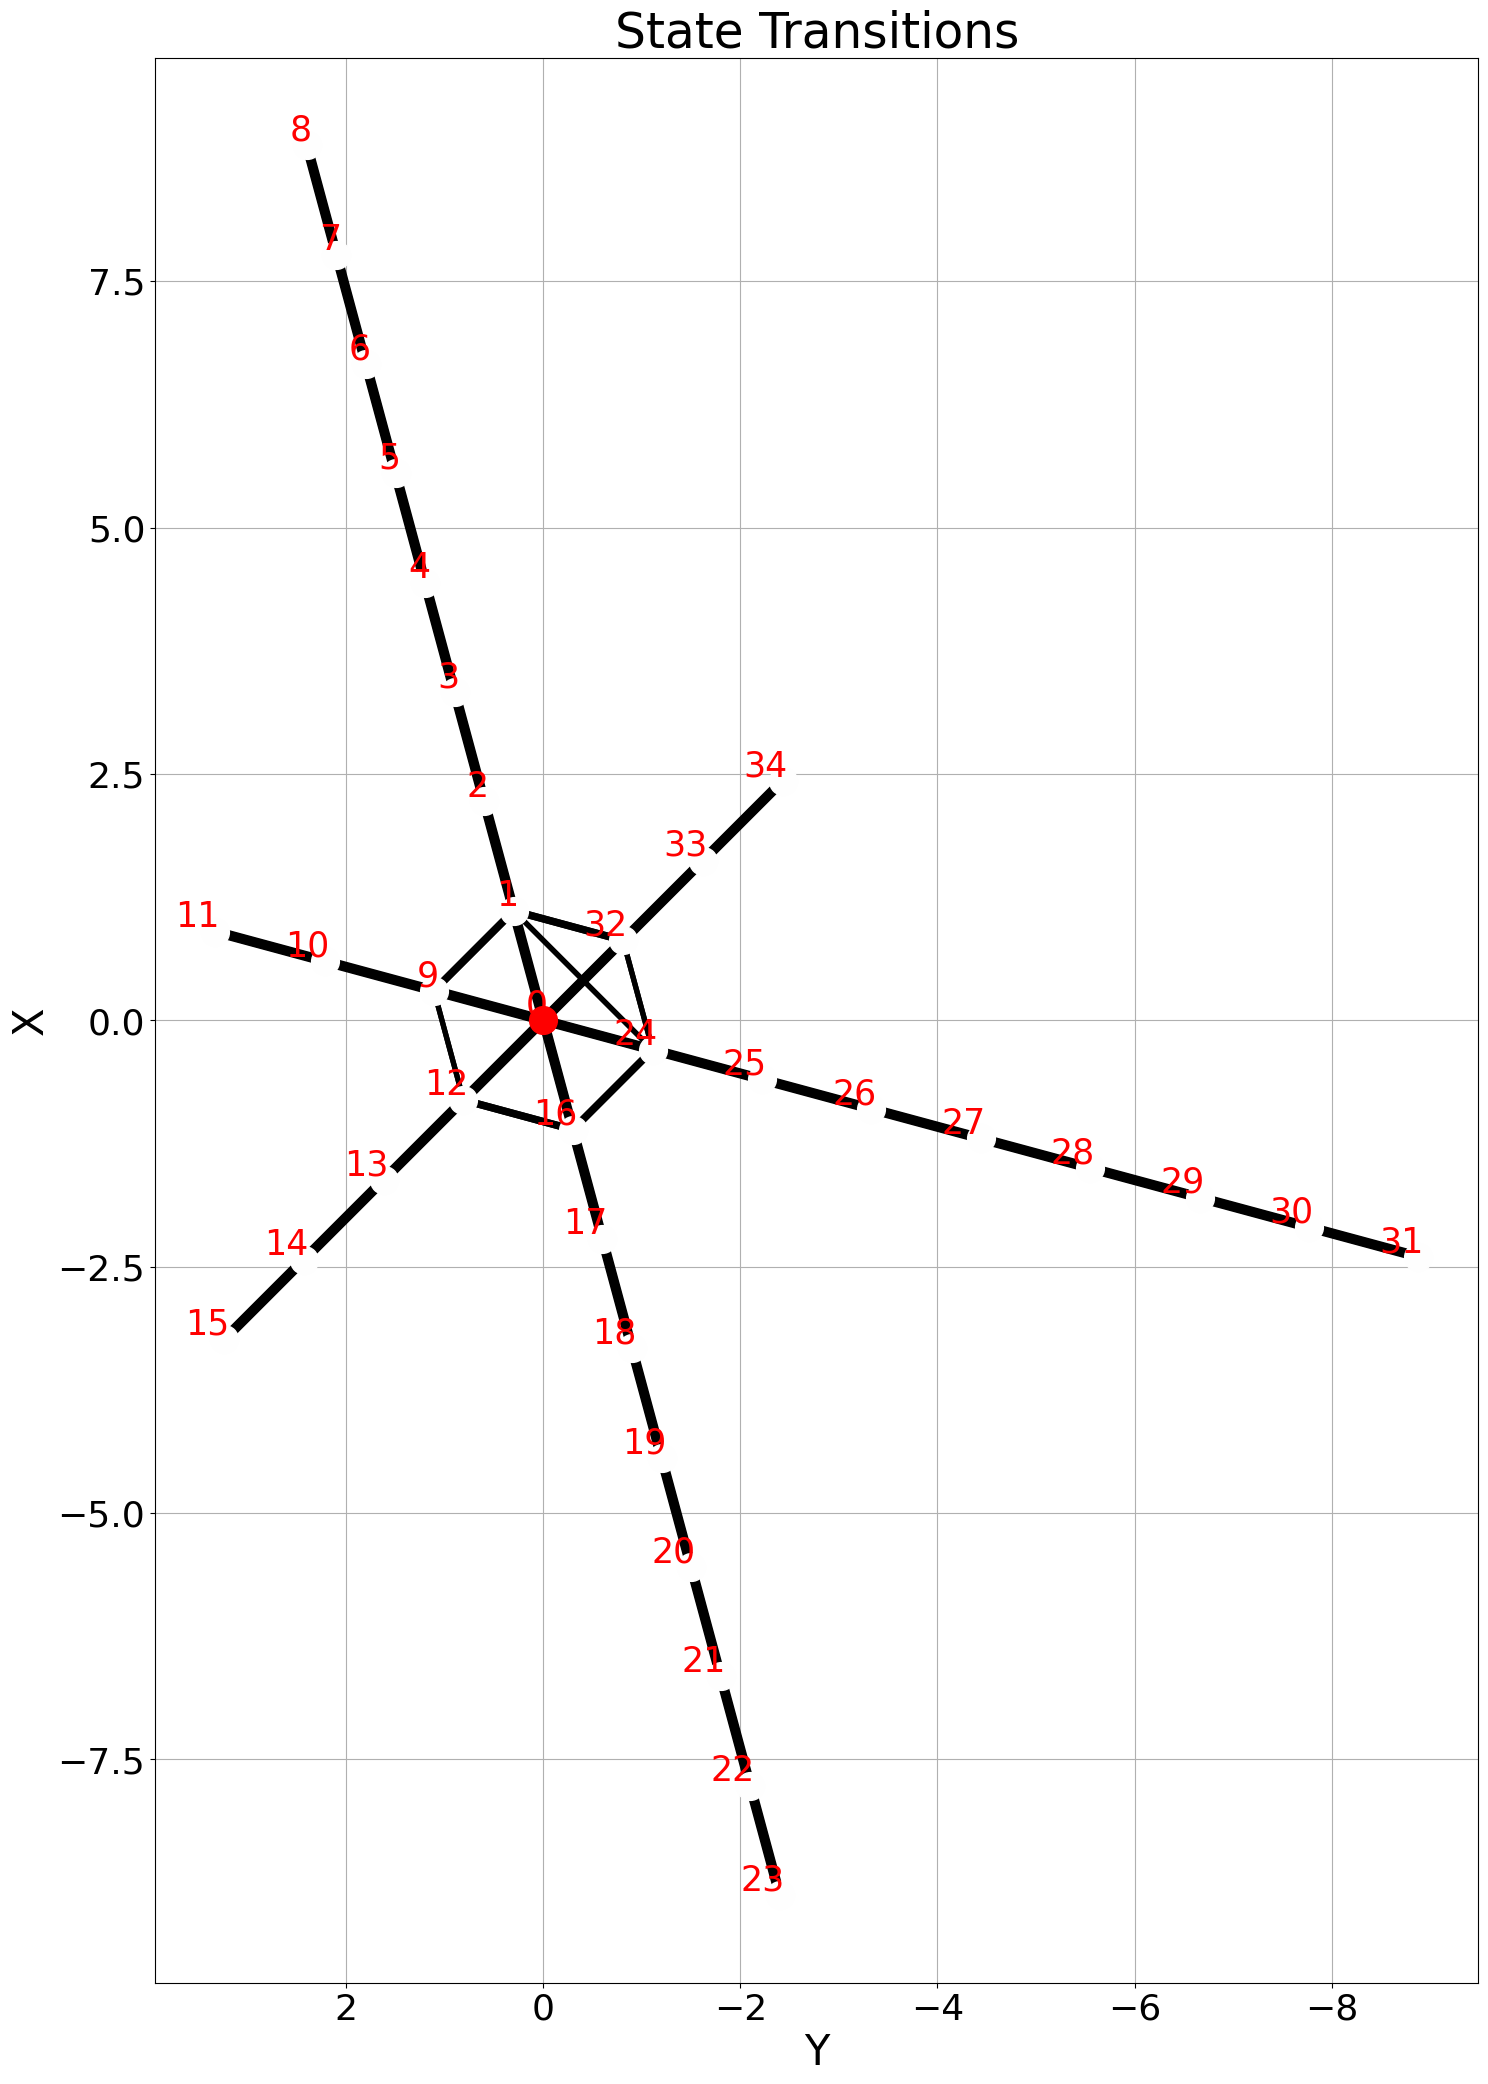

In [63]:
fig = plot_state_in_map(ours.get_B(), ours.get_agent_state_mapping())
plt.grid('True')
#plt.show()
fig.canvas.draw()


In [62]:
fig.clear()

In [47]:
stop

NameError: name 'stop' is not defined

# Update model

In [67]:
ours.use_states_info_gain = True 
ours.use_utility = False
ours.use_inductive_inference = False
ours.use_param_info_gain = False #if true, do not use with the other terms

In [ ]:
possible_actions = ours.define_next_possible_actions(obstacle_dist_per_actions, restrictive=True)
possible_actions = {k: ours.possible_actions[k] for k in possible_actions}
actions, data = ours.define_actions_from_MCTS_run(num_steps=1, observations=[ob_id],next_possible_actions=list(possible_actions.keys()), logging=logging, plot_MCTS_tree=False)

2025-09-08 16:21:12,583 - INFO - MCTS_Model_Interface initialized with model type: <class 'aimapp.model.V5.Ours_V5_RW'>
2025-09-08 16:21:12,587 - INFO - MCTS initialized with exploration parameter c=5, num_simus=30, max_depth=10, policy_alpha=16.0,  action_selection=stochastic
2025-09-08 16:21:14,814 - INFO - Root node children stats: Action 0: AvgR=0.263, N=8; Action 2: AvgR=0.267, N=4; Action 4: AvgR=0.264, N=4; Action 6: AvgR=0.265, N=4; Action 8: AvgR=0.255, N=4; Action 10: AvgR=0.259, N=4; Action 12: AvgR=0.500, N=1
2025-09-08 16:21:14,816 - INFO - action average G: [0.2629545461807035, 0.2665154416196558, 0.264198439614478, 0.2651390624445388, 0.25541948790300173, 0.2587774565604145, 0.4997709291527662]
2025-09-08 16:21:14,817 - INFO - softmax policies: [0.02 0.02 0.02 0.02 0.02 0.02 0.88]
2025-09-08 16:21:14,818 - INFO - Selected best action based on policy: 12
2025-09-08 16:21:14,819 - INFO - MCTS:Executing actions [12] -> Transitioning up to Node 0


next action

In [70]:
print('action', actions[0], ' qpi ', str(data['qpi'][0]), ' efe ', str(data['efe'][0]))

action 12  qpi  [0.01993978682748574, 0, 0.021108829249526107, 0, 0.020340609763667642, 0, 0.02064905042318024, 0, 0.017675087130061815, 0, 0.018650699271813113, 0, 0.8816359373342654]  efe  [0.2629545461807035, 0, 0.2665154416196558, 0, 0.264198439614478, 0, 0.2651390624445388, 0, 0.25541948790300173, 0, 0.2587774565604145, 0, 0.4997709291527662]


current qs:

In [71]:
ours.get_belief_over_states()[0].round(3)

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [72]:
prior = ours.infer_states([ob_id,pose_id], save_hist=False)
prior

array([array([1.00000000e+00, 5.09999745e-19, 5.00049750e-18, 5.00049750e-18,
              5.00049750e-18, 5.00049750e-18, 5.00049750e-18, 5.00049750e-18,
              5.00049750e-18, 5.00049750e-18, 5.00049750e-18, 5.00049750e-18,
              5.00049750e-18, 5.00049750e-18, 5.00049750e-18, 5.00049750e-18,
              5.00049750e-18, 5.00049750e-18, 5.00049750e-18, 5.00049750e-18,
              5.00049750e-18, 5.00049750e-18, 5.00049750e-18, 5.00049750e-18,
              5.00049750e-18, 5.00049750e-18, 5.00049750e-18, 5.00049750e-18,
              5.00049750e-18, 5.00049750e-18, 5.00049750e-18, 5.00049750e-18,
              5.00049750e-18, 5.00049750e-18, 5.00049750e-18])               ],
      dtype=object)

In [ ]:
data

## STEP1

### step 1

In [74]:
#STEP4 NO OB
ob_id_step1 = 1
obstacles_step1 = [16.807, 7.002, 3.485, 2.0879, 4.285, 13.905, 14.785, 5.634, 19.275, 5.747, 4.0156, 7.973]
step1_action = actions[0]

In [76]:
ours.set_action_step(step1_action)
ours.agent_step_update(step1_action, [ob_id_step1, obstacles_step1], logs=logging)

2025-09-08 16:23:27,862 - INFO - observations pose 0.000000, action 12.000000, ob_id 1.000000, obstacles [16.807, 7.002, 3.485, 2.0879, 4.285, 13.905, 14.785, 5.634, 19.275, 5.747, 4.0156, 7.973]


update_B: a 12 qs[factor] [0.377 0.002 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019
 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019
 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019 0.019] qs_prev[factor] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
update_B: a 0 qs[factor] [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] qs_prev[factor] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
update_B: a 6 qs[factor] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] qs_prev[factor] [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
update_B: a 0 qs[factor] [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.

In [82]:
ours.qs[0].round(3)

array([0.16 , 0.019, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025])

In [83]:
ours.infer_current_most_likely_pose(observations= [ob_id_step1], z_score=5)

0

# PLOT

In [77]:
ours.agent_state_mapping

{(0.0, 0.0): {'state': 0, 'ob': 0, 'ob2': 0},
 (1.11, 0.3): {'state': 1, 'ob': -1, 'ob2': 1},
 (2.22, 0.6): {'state': 2, 'ob': -1, 'ob2': 2},
 (3.33, 0.9): {'state': 3, 'ob': -1, 'ob2': 3},
 (4.44, 1.2): {'state': 4, 'ob': -1, 'ob2': 4},
 (5.55, 1.5): {'state': 5, 'ob': -1, 'ob2': 5},
 (6.66, 1.8): {'state': 6, 'ob': -1, 'ob2': 6},
 (7.77, 2.1): {'state': 7, 'ob': -1, 'ob2': 7},
 (8.88, 2.4): {'state': 8, 'ob': -1, 'ob2': 8},
 (0.3, 1.11): {'state': 9, 'ob': -1, 'ob2': 9},
 (0.6, 2.22): {'state': 10, 'ob': -1, 'ob2': 10},
 (0.9, 3.33): {'state': 11, 'ob': -1, 'ob2': 11},
 (-0.81, 0.81): {'state': 12, 'ob': -1, 'ob2': 12},
 (-1.62, 1.62): {'state': 13, 'ob': -1, 'ob2': 13},
 (-2.43, 2.43): {'state': 14, 'ob': -1, 'ob2': 14},
 (-3.24, 3.24): {'state': 15, 'ob': -1, 'ob2': 15},
 (-1.11, -0.3): {'state': 16, 'ob': -1, 'ob2': 16},
 (-2.22, -0.6): {'state': 17, 'ob': -1, 'ob2': 17},
 (-3.33, -0.9): {'state': 18, 'ob': -1, 'ob2': 18},
 (-4.44, -1.2): {'state': 19, 'ob': -1, 'ob2': 19},
 (-5.5

In [78]:
print(ours.B[0].shape)
ours.agent_state_mapping

(35, 35, 13)


{(0.0, 0.0): {'state': 0, 'ob': 0, 'ob2': 0},
 (1.11, 0.3): {'state': 1, 'ob': -1, 'ob2': 1},
 (2.22, 0.6): {'state': 2, 'ob': -1, 'ob2': 2},
 (3.33, 0.9): {'state': 3, 'ob': -1, 'ob2': 3},
 (4.44, 1.2): {'state': 4, 'ob': -1, 'ob2': 4},
 (5.55, 1.5): {'state': 5, 'ob': -1, 'ob2': 5},
 (6.66, 1.8): {'state': 6, 'ob': -1, 'ob2': 6},
 (7.77, 2.1): {'state': 7, 'ob': -1, 'ob2': 7},
 (8.88, 2.4): {'state': 8, 'ob': -1, 'ob2': 8},
 (0.3, 1.11): {'state': 9, 'ob': -1, 'ob2': 9},
 (0.6, 2.22): {'state': 10, 'ob': -1, 'ob2': 10},
 (0.9, 3.33): {'state': 11, 'ob': -1, 'ob2': 11},
 (-0.81, 0.81): {'state': 12, 'ob': -1, 'ob2': 12},
 (-1.62, 1.62): {'state': 13, 'ob': -1, 'ob2': 13},
 (-2.43, 2.43): {'state': 14, 'ob': -1, 'ob2': 14},
 (-3.24, 3.24): {'state': 15, 'ob': -1, 'ob2': 15},
 (-1.11, -0.3): {'state': 16, 'ob': -1, 'ob2': 16},
 (-2.22, -0.6): {'state': 17, 'ob': -1, 'ob2': 17},
 (-3.33, -0.9): {'state': 18, 'ob': -1, 'ob2': 18},
 (-4.44, -1.2): {'state': 19, 'ob': -1, 'ob2': 19},
 (-5.5

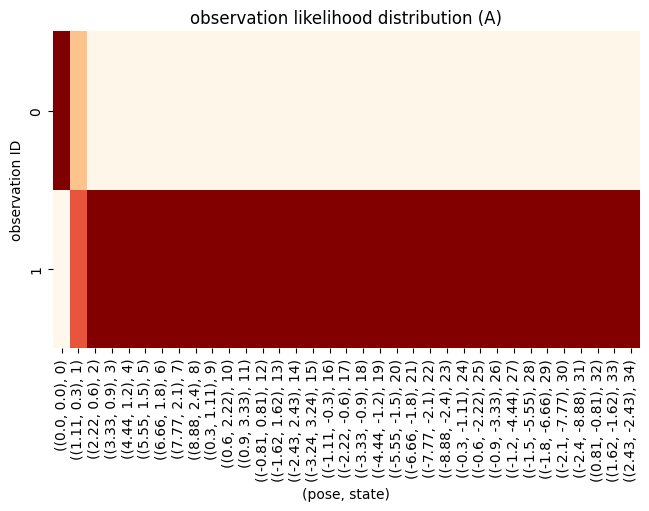

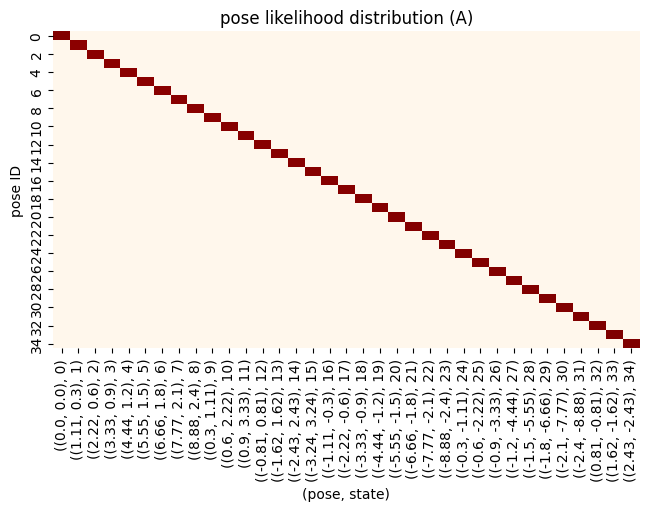

In [81]:
A0 = plot_likelihood(ours.A[0], ours.agent_state_mapping, tittle_add='observation')
A1 = plot_likelihood(ours.A[1], ours.agent_state_mapping, tittle_add='pose')

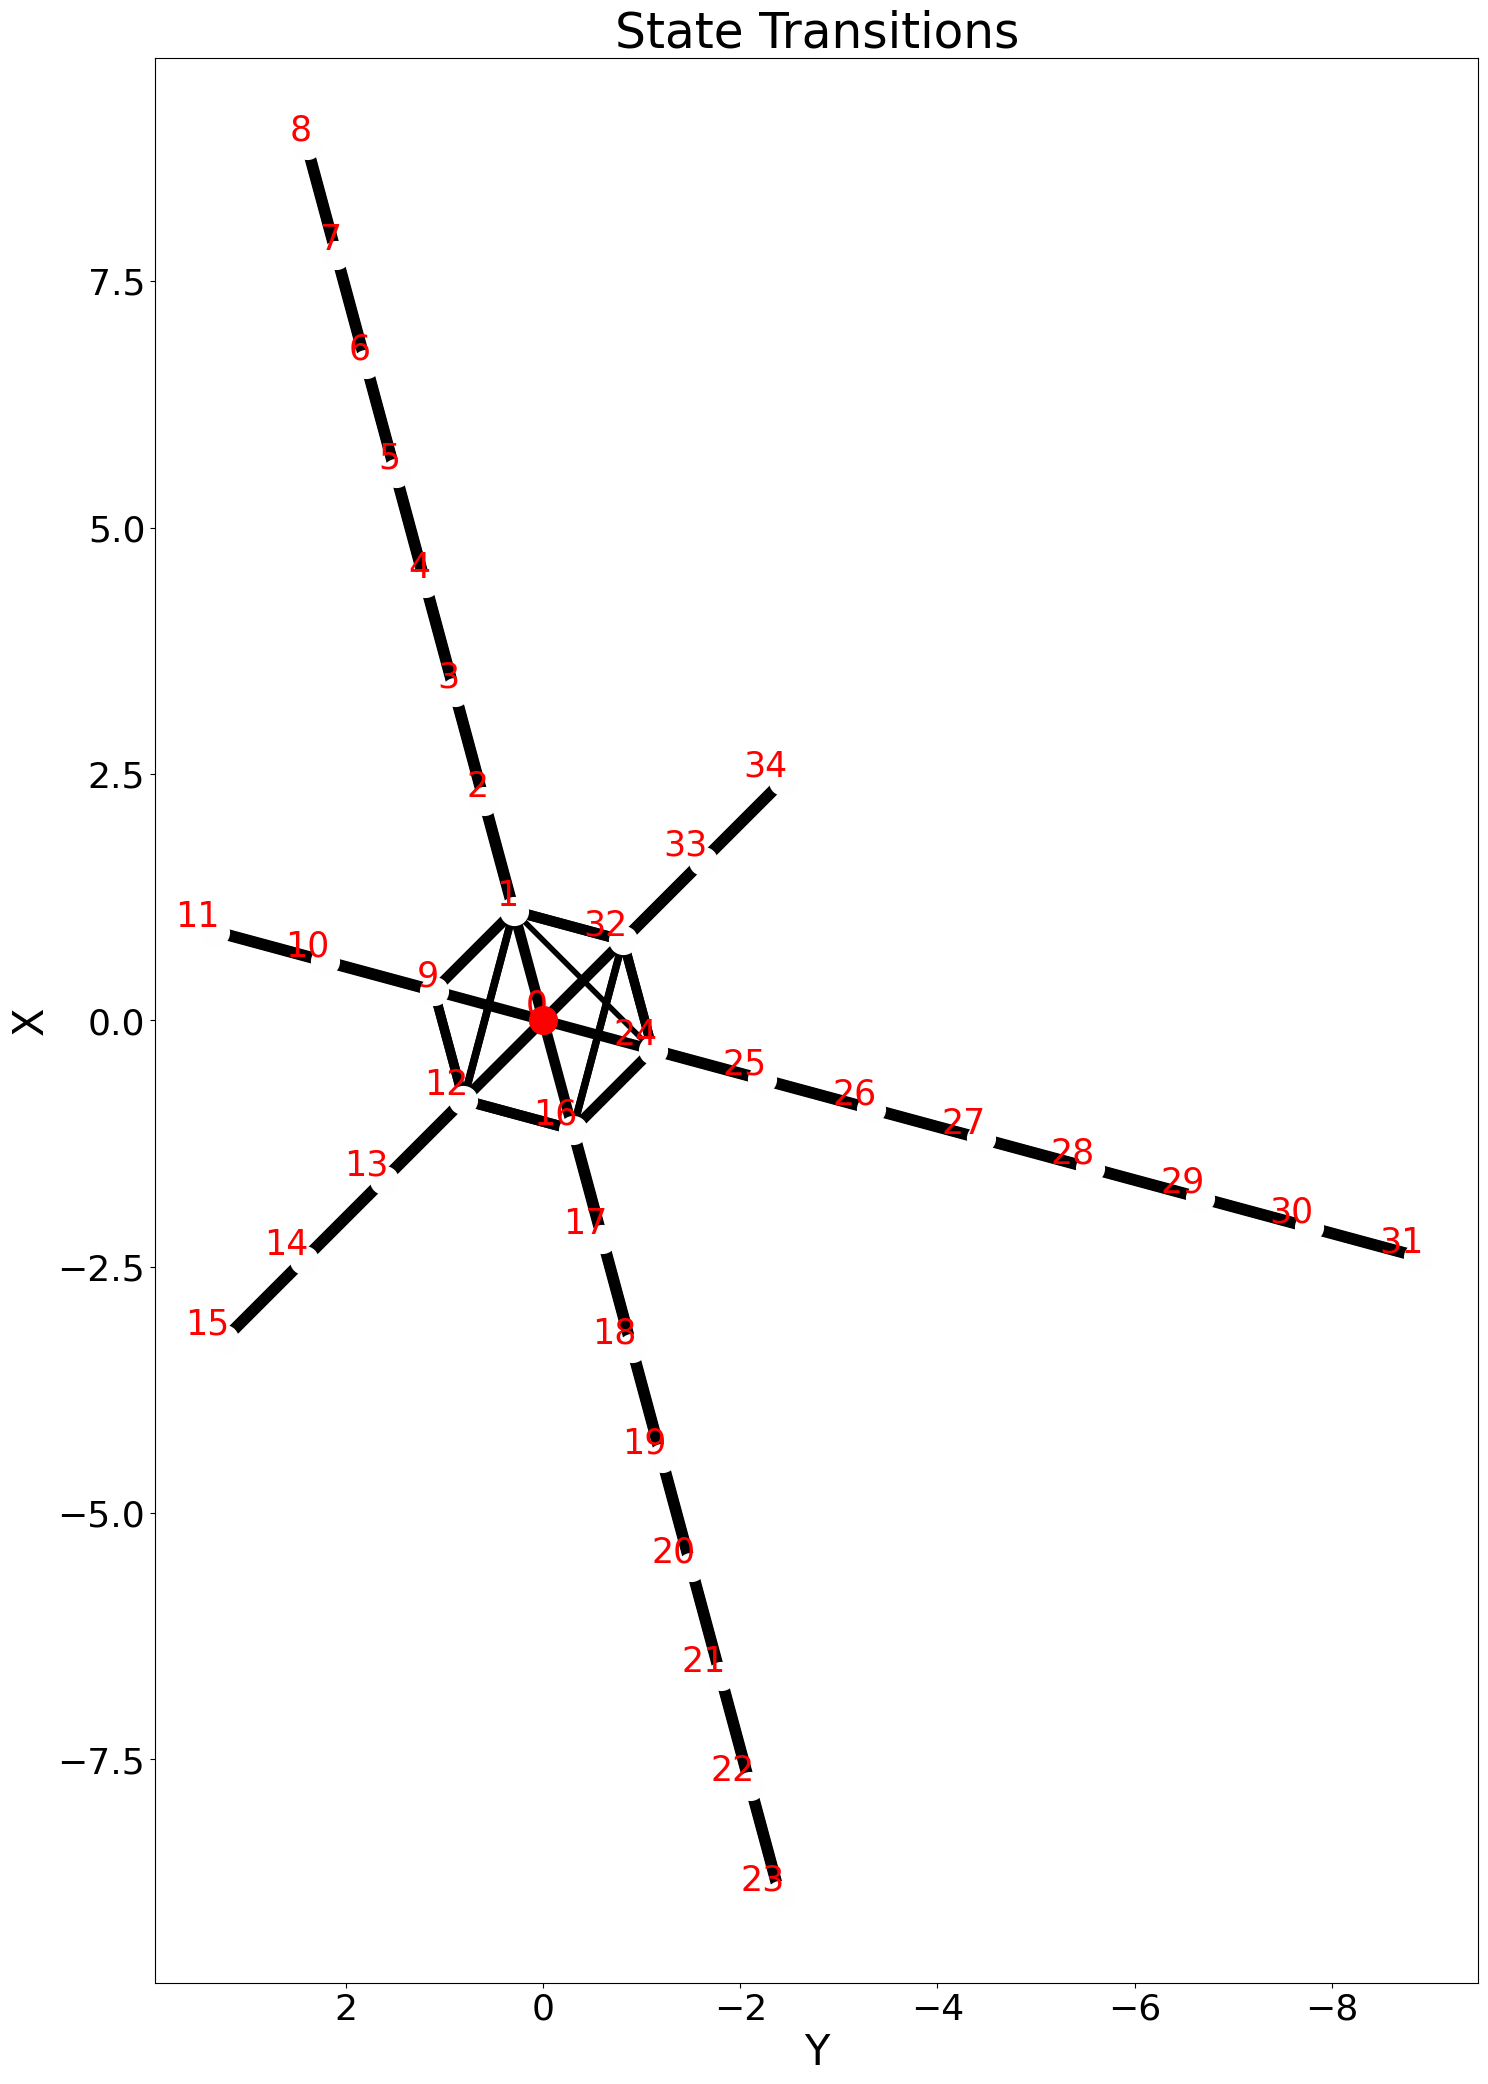

In [80]:
plot = plot_state_in_map(ours.B[0], ours.agent_state_mapping)

labels ['(0.0, 0.0) (0)', '(1.11, 0.3) (1)', '(2.22, 0.6) (2)', '(3.33, 0.9) (3)', '(4.44, 1.2) (4)', '(5.55, 1.5) (5)', '(6.66, 1.8) (6)', '(7.77, 2.1) (7)', '(8.88, 2.4) (8)', '(0.3, 1.11) (9)', '(0.6, 2.22) (10)', '(0.9, 3.33) (11)', '(-0.81, 0.81) (12)', '(-1.62, 1.62) (13)', '(-2.43, 2.43) (14)', '(-3.24, 3.24) (15)', '(-1.11, -0.3) (16)', '(-2.22, -0.6) (17)', '(-3.33, -0.9) (18)', '(-4.44, -1.2) (19)', '(-5.55, -1.5) (20)', '(-6.66, -1.8) (21)', '(-7.77, -2.1) (22)', '(-8.88, -2.4) (23)', '(-0.3, -1.11) (24)', '(-0.6, -2.22) (25)', '(-0.9, -3.33) (26)', '(-1.2, -4.44) (27)', '(-1.5, -5.55) (28)', '(-1.8, -6.66) (29)', '(-2.1, -7.77) (30)', '(-2.4, -8.88) (31)', '(0.81, -0.81) (32)', '(1.62, -1.62) (33)', '(2.43, -2.43) (34)']
L and l 4 4


KeyboardInterrupt: 

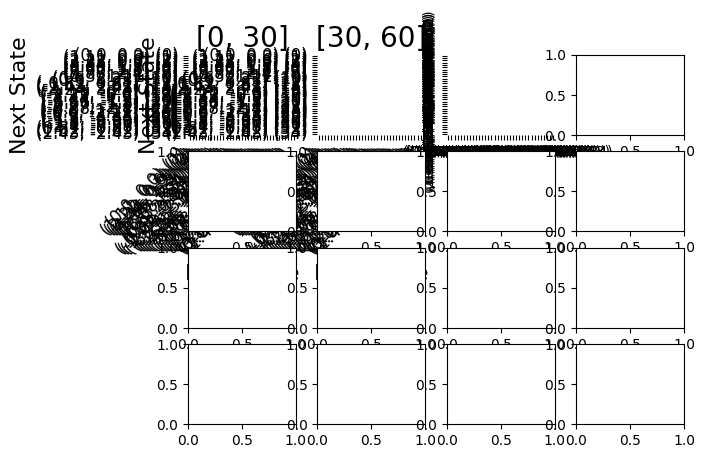

In [79]:
B_plot = plot_transitions(ours.B[0], ours.agent_state_mapping, ours.possible_actions)

## step2

In [ ]:
possible_actions = ours.define_next_possible_actions(obstacle_dist_per_actions, restrictive=True)
possible_actions = {k: ours.possible_actions[k] for k in possible_actions}
actions, data = ours.define_actions_from_MCTS_run(num_steps=1, observations=[ob_id_step1],next_possible_actions=list(possible_actions.keys()), logging=logging, plot_MCTS_tree=False)

2025-09-08 16:29:19,180 - INFO - MCTS_Model_Interface initialized with model type: <class 'aimapp.model.V5.Ours_V5_RW'>
2025-09-08 16:29:19,182 - INFO - MCTS initialized with exploration parameter c=5, num_simus=30, max_depth=10, policy_alpha=16.0,  action_selection=stochastic
2025-09-08 16:29:21,405 - INFO - Root node children stats: Action 0: AvgR=6.703, N=8; Action 2: AvgR=6.759, N=4; Action 4: AvgR=6.783, N=4; Action 6: AvgR=6.812, N=4; Action 8: AvgR=6.861, N=4; Action 10: AvgR=6.861, N=4; Action 12: AvgR=6.502, N=1
2025-09-08 16:29:21,418 - INFO - action average G: [6.702701080869389, 6.759028032363509, 6.782862785677708, 6.812442413339546, 6.860781163316151, 6.860781163316151, 6.502137121409497]
2025-09-08 16:29:21,420 - INFO - softmax policies: [0.03 0.06 0.09 0.15 0.33 0.33 0.  ]
2025-09-08 16:29:21,421 - INFO - Selected best action based on policy: 10
2025-09-08 16:29:21,423 - INFO - MCTS:Executing actions [10] -> Transitioning up to Node 32


next action

In [85]:
print('action', actions[0], ' qpi ', str(data['qpi'][0]), ' efe ', str(data['efe'][0]))

action 10  qpi  [0.02632521616431207, 0, 0.06482935391231627, 0, 0.09492760479401303, 0, 0.15238170481165875, 0, 0.33023634282732217, 0, 0.33023634282732217, 0, 0.0010634346630554528]  efe  [6.702701080869389, 0, 6.759028032363509, 0, 6.782862785677708, 0, 6.812442413339546, 0, 6.860781163316151, 0, 6.860781163316151, 0, 6.502137121409497]


current qs:

In [86]:
ours.get_belief_over_states()[0].round(3)

array([0.16 , 0.019, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025])

In [92]:
prior = ours.infer_states([ob_id,pose_id], save_hist=False)
prior

array([array([1.00000000e+00, 2.05339235e-17, 2.00035116e-17, 2.00035705e-17,
              2.00036295e-17, 2.00036886e-17, 2.00037478e-17, 2.00038072e-17,
              2.00038666e-17, 2.00040154e-17, 2.00040246e-17, 2.00040456e-17,
              2.12189756e-17, 2.12157288e-17, 2.12101399e-17, 1.99999039e-17,
              2.00000012e-17, 2.00000246e-17, 2.00000851e-17, 2.00001458e-17,
              2.00002066e-17, 2.00002675e-17, 2.00003285e-17, 2.00003896e-17,
              2.11313799e-17, 2.00000793e-17, 2.00001407e-17, 2.00002023e-17,
              2.00002640e-17, 2.00003258e-17, 2.00003878e-17, 2.00004499e-17,
              3.88362787e-15, 1.94883328e-17, 1.99078728e-17])               ],
      dtype=object)

In [88]:
#STEP4 NO OB
ob_id_step2 = 2
obstacles_step2 = [17.807, 7.002, 3.485, 2.0879, 4.285, 13.905, 14.785, 5.634, 19.275, 4.747, 3.0156, 6.973]
step2_action = actions[0]

In [89]:
ours.set_action_step(step2_action)
ours.agent_step_update(step2_action, [ob_id_step2, obstacles_step2], logs=logging)

2025-09-08 16:30:32,894 - INFO - observations pose 0.000000, action 10.000000, ob_id 2.000000, obstacles [17.807, 7.002, 3.485, 2.0879, 4.285, 13.905, 14.785, 5.634, 19.275, 4.747, 3.0156, 6.973]


update_B: a 10 qs[factor] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] qs_prev[factor] [0.16  0.019 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.025]
update_B: a 0 qs[factor] [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] qs_prev[factor] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
update_B: a 6 qs[factor] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] qs_prev[factor] [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
update_B: a 0 qs[factor] [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.

In [91]:
ours.qs[0].round(3)

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])